# Lab 04: Neural Network Embedding for Places 
In this lab, we will go through experiments of computing word embedding, document embedding, topic modeling, and embedding visualization. It involves the implementaton of several state-of-the-art techniques, including word2vec, TSNS, and LDA. We will use the same data as Lab 03. Similarities and differences between Lab 3 and Lab 4 will also be discussed.  

Used packages include:
* geopandas
* pandas
* jsom
* shapely
* [gensim](https://radimrehurek.com/gensim/index.html)
* sklearn
* [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html#installation)
* numpy
* matplotlib
* random

Yes! You have already used most of these libraries. 

We will learn two more new libraries here: `gensim` and `pyLDAvis`. Particularly for `gensim`, it is an important library in modern natural language processing. Make sure your installed `gensim` is in the version of 4.2.0 or later.

In [70]:
import gensim
print(gensim.__version__)

4.2.0


## Part 1: Word2Vec to Learn Semantic Similarity between Place Types 
The first part is about to train a Word2Vec model using the library `gensim`. Similar to Lab 03, we want to represent place types (unstructured words representing the category of places/POIs) using a numeric vector. Different from Lab 03, we want to capture more semantics (e.g., how words are used together in the document) than simply counting the frequency of terms occurred in the document. As discussed in the lecture, Wrod2Vec is the fundemental for most state-of-the-art natural language processing techniques, such as [BERT](https://arxiv.org/abs/1810.04805), which is developed by Google and has been used in their search engine. 

Before we use the model, we must load the data. Here in the tutorial, we will use exactly the same data you created from Lab 03, i.e., the `bristol_lsoal_poi_full` dataframe. Recall that it is a dataframe with each row represent a LSOA11 region, and it contains a column named `fclass` that includes POI types that have been seen in this region. Like Lab 03, we will still regard each LSOA11 region as a document and the POI types from the `fclass` column as words composing the document. However, you should note that such a setup is simply for us to do the experiment as the vocabulary here (all unique POI types) is relatively in small size and the number of documents (regions) is also small. Data-driven (Neural Network)techniques, like the Word2Vec, usually require a large data/corpus. In your future projects, you should not limit yourself to only small datasets (even though starting from a relatively smaller data is always a good idea). 

In case, you have not saved the `bristol_lsoal_poi_full` dataframe, I have prepared it for you and you can download it from the Blackboard. Once you get the data, you can use the code below to load it. Remember to assign a crs to the dataframe. Also the parameter `wkt.loads` is to tell the dataframe that the coloumn `geom` is as the WKT format. The `converters = {}` parameter is to tell pandas that while loading the data, delete the list bracket `[]` and then split the string using `, `. Try to see what you load if you don't use such a `converters = {}`. 

In [3]:
# load the data 
import geopandas as gpd
import pandas as pd
import json
from shapely.geometry import shape
from shapely import wkt
import gensim # make sure it is in the version of 4.2.0 or later 



bristol_lsoal_poi_full = pd.read_csv('bristol_lsoal_poi_full.csv', sep = '\t',converters={"fclass": lambda x: x.strip("[]").split(", ")})
bristol_lsoal_poi_full['geom'] = bristol_lsoal_poi_full['geom'].apply(wkt.loads)
bristol_lsoal_poi_full = gpd.GeoDataFrame(bristol_lsoal_poi_full,crs="EPSG:4326", geometry= "geom")

After loading the data, we need to prepare a document list (called `corpus` here) as the input to the model. This `corpus` is a list of list, the outter is a document list, and the inner list is a word list that composing the document. See how it looks like below:

In [4]:
corpus = list(bristol_lsoal_poi_full['fclass'])
corpus

[["'swimming_pool'", "'swimming_pool'", "'playground'", "'park'"],
 ["'convenience'",
  "'convenience'",
  "'nursing_home'",
  "'college'",
  "'hairdresser'",
  "'computer_shop'",
  "'fast_food'",
  "'restaurant'",
  "'doityourself'",
  "'car_wash'",
  "'convenience'",
  "'restaurant'",
  "'sports_centre'",
  "'clinic'",
  "'hairdresser'",
  "'sports_centre'",
  "'doityourself'",
  "'car_dealership'",
  "'restaurant'",
  "'dentist'",
  "'kindergarten'",
  "'community_centre'",
  "'cafe'",
  "'doityourself'",
  "'butcher'",
  "'theatre'",
  "'sports_centre'"],
 ["'kindergarten'",
  "'community_centre'",
  "'kindergarten'",
  "'convenience'",
  "'hairdresser'",
  "'fast_food'",
  "'playground'",
  "'park'",
  "'park'",
  "'convenience'",
  "'cafe'",
  "'fast_food'",
  "'fast_food'",
  "'hairdresser'",
  "'beauty_shop'"],
 ["'sports_shop'",
  "'beauty_shop'",
  "'convenience'",
  "'fast_food'",
  "'pub'",
  "'car_dealership'",
  "'playground'",
  "'pitch'",
  "'pitch'",
  "'toy_shop'",
  

With such a `corpus`, we then can train the neural network to learn the embedding for words in the corpus based on their use in the document. All the detailed processes (e.g., initializing, sampling, optimization, etc.) are encapsulated in the function called `Word2Vec` provided by `gensim`'s `models` module (it also includes other advanced NLP models such as `ldamodel`). 

In [6]:
# train the model
model = gensim.models.Word2Vec(corpus, min_count=1, vector_size=100, workers=3, window =3, sg = 1)

For the full documentation of `Word2Vec`, please check it official webpage: https://radimrehurek.com/gensim/models/word2vec.html. In this example, you will see in the parameters `corpus`, the input; `min_count`, if the frequency of a word is less than it, it will not be considered in the model; `vector_size`, dimensionality of the word embedding vector; `workers`, the number of worker threads to train the model (it depends on your systems capability); `window`,  maximum distance between the current and predicted word (define the length of the context); `sg`, training algorithm: 1 for skip-gram; otherwise CBOW. 

How to determine these parameters sometimes depends on modeler's experience as well as the experiment results. In general Machine Learning (ML)/Deep Learning (DL) field, scientists usually conduct a lot of experienment in order to tune the model to its best performance. 

You will learn more about these ML/DP methods in the Geographic Data Science unit offered next term. 

Now, with the trained `model`, we can see the word embedding of any word (place type here) by using code below. Note that `wv` is short for word vector.  

In [7]:
model.wv["'swimming_pool'"]

array([-0.078685  ,  0.15542258, -0.02243728,  0.07809819,  0.0626849 ,
       -0.17506836,  0.04474231,  0.2081272 , -0.13518876, -0.16856214,
       -0.00936876, -0.17530474,  0.01920592,  0.06494125,  0.07890015,
       -0.09049974,  0.13964482, -0.06258468,  0.02220418, -0.2401684 ,
        0.07719522,  0.04147687,  0.23926066, -0.08266466, -0.04260313,
        0.02942185, -0.18089841,  0.06170766, -0.07240284,  0.01278588,
        0.18554498, -0.03862391,  0.10925481, -0.22881286, -0.03959438,
        0.08083871, -0.04443993, -0.03407257, -0.05998663, -0.09209065,
        0.08889414, -0.13964161,  0.02546454,  0.04552469,  0.09247475,
       -0.0718627 , -0.13203259, -0.13340887,  0.0725301 ,  0.02472993,
        0.1134716 , -0.05348552, -0.02400114, -0.06314865, -0.05117393,
       -0.00187449,  0.06196024, -0.021495  , -0.12580968, -0.01221896,
        0.05093616,  0.03001299,  0.10772882,  0.12132879, -0.03753583,
        0.19692196, -0.01060558,  0.19042434, -0.2138441 ,  0.07

Same to what we have done in Lab 03, we next can compute the simiarlity between these vectors. Here are where the "magic" comes from. The semantics of these qualitative terms becomes computable, which empowers us, assisted by the machine, to conduct a lot of interesting analyses/processes.  

For instance, we can compute the (semantic) simiarity between words (place types):

In [28]:
# compute similairity 
sim_restaurant_park = model.wv.similarity("'cafe'", "'park'")
sim_restaurant_park

0.9949972

In [29]:
sim_restaurant_fastFood = model.wv.similarity("'cafe'", "'fast_food'")
sim_restaurant_fastFood

0.99709475

First, you can see that the similarity between `cafe` and `park` is smaller than `cafe` and `fast food`, which aligns to our intuition. Next, we can also use the built-in function `most_similar()` to get the most similar word to the target:

In [14]:
model.wv.most_similar("'cafe'")[:5]

[("'travel_agent'", 0.9977251291275024),
 ("'bakery'", 0.9977040886878967),
 ("'outdoor_shop'", 0.9976357817649841),
 ("'arts_centre'", 0.9976053833961487),
 ("'mall'", 0.9975782036781311)]

Note that such a similarity is computed based on Euclidean distance. Here, we can also implement the version of computing cosine simiarity (you acatully have done it in previous labs). Before doing that, we need to function to get the vocabulary based on the corpus:

In [30]:
# get the vocabulary of the corpus 
def voc_generator(corpus):
    voc = []
    for doc in corpus:
        for word in doc:
            voc.append(word)
    voc = list(set(voc))
    return voc

voc = voc_generator(corpus)
voc

["'tourist_info'",
 "'greengrocer'",
 "'clinic'",
 "'beauty_shop'",
 "'video_shop'",
 "'hotel'",
 "'bar'",
 "'sports_shop'",
 "'veterinary'",
 "'cafe'",
 "'nightclub'",
 "'car_wash'",
 "'car_rental'",
 "'stadium'",
 "'comms_tower'",
 "'camp_site'",
 "'nursing_home'",
 "'police'",
 "'furniture_shop'",
 "'pharmacy'",
 "'attraction'",
 "'doityourself'",
 "'cinema'",
 "'restaurant'",
 "'toy_shop'",
 "'travel_agent'",
 "'hairdresser'",
 "'town_hall'",
 "'mall'",
 "'castle'",
 "'market_place'",
 "'water_works'",
 "'laundry'",
 "'water_tower'",
 "'convenience'",
 "'college'",
 "'theme_park'",
 "'pub'",
 "'shoe_shop'",
 "'garden_centre'",
 "'doctors'",
 "'university'",
 "'hostel'",
 "'newsagent'",
 "'post_office'",
 "'chemist'",
 "'toilet'",
 "'clothes'",
 "'bank'",
 "'park'",
 "'nan'",
 "'kindergarten'",
 "'wastewater_plant'",
 "'car_dealership'",
 "'monument'",
 "'bookshop'",
 "'memorial'",
 "'graveyard'",
 "'theatre'",
 "'shelter'",
 "'bicycle_shop'",
 "'golf_course'",
 "'public_building'",

The below function is to compute the cosine similarity, which is slightly different than what we have implemented before; but the core is the same! Try to read it and see if you can understand the code. It is to show you that in Python, you have the flexibilty to write any functions. Different people might write the function in different ways to achieve the same thing. 

In [15]:
# compute Cosine similarity 
import numpy as np
from numpy.linalg import norm

def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in target_list :
        if item != word :
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

Now, we can test the function by checking the top 5 similar words for 'cafe' based on its cosine similarity with other word vectors:

In [17]:
cosine_distance (model,"'cafe'",voc,5)

[("'travel_agent'", 0.9977251),
 ("'bakery'", 0.99770415),
 ("'outdoor_shop'", 0.9976358),
 ("'arts_centre'", 0.9976055),
 ("'mall'", 0.99757826)]

Okay! So far you have learnt and implemented the very fundemental technique in NLP/Geospatial Semantics: Word2Vec. Such a quantitative representation of semantics facilitates us to do many interesting things in addition to simply computing similarities between words. For instance, you can use the word vectors to cluster/group words, to execute calssification when seeing a new word, to predict the next words giving a set of seen words, etc. Again, be creative in your future projects. 

## Part 2: Visualizing Word Embedding 
In Lab 3, we learned a technique called WordCloud to visulize natural language based on the frequency of terms. WordCloud can only tell us which word occurs the most in the document without having any implications on the meaning of these words. With word embedding, we can now visulize natural language based on their semantics. In the code below, we implememt a technique called TSNE (t-distributed stochastic neighbor embedding). It maps the high dimensional vector into 2-dimension (2D), so that words' embeddings can now be mapped onto a plane. During such a mapping, TSNE attempts to keep the intrinsic relationships between the embeddings in the original high dimension. There are many mathematical formulas involved in this technique, which is beyond the scope of this unit. But if you are interested at the details (not required), check https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding. 

Basically, in the code below, we take advantage of the [`sklearn`](https://scikit-learn.org/stable/) library's TSNE package, where the mapping will be produced. Then we extract the 2 dimensions as `x-val` and `y-val`. Finally, we use [`matplotlib`](https://matplotlib.org/) to visualize the 2 dimensions as a 2D plot. During the process, we also randonly selected 25 words (place types) and label them on the plot.  

Note that we have used both `sklearn` and `matplotlib` already in previous labs. Indeed, these libraries introduced in this unit are the main ones (spatial/geographical) data scientists often use. You will get more and more familiar of using them in your career. 

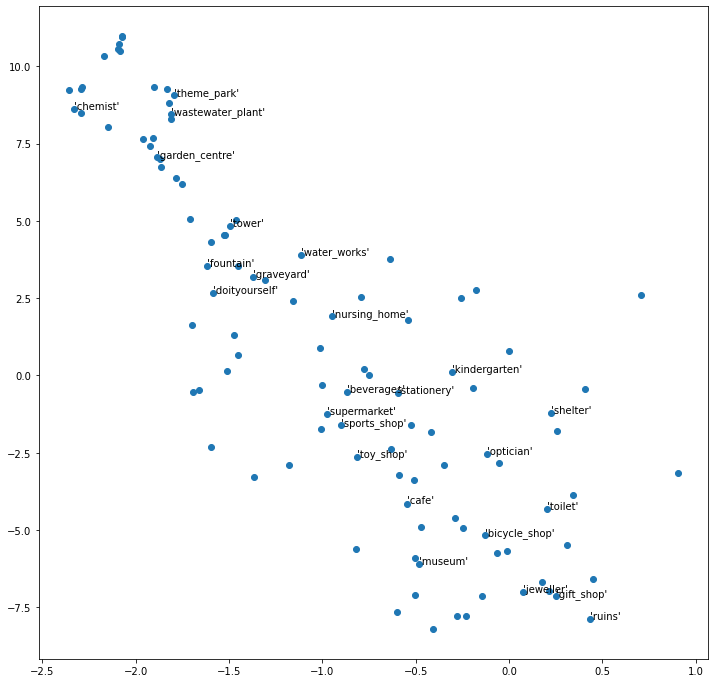

In [18]:
## tsn visualization 
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE               
import numpy as np                      
import matplotlib.pyplot as plt
import random

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_matplotlib(x_vals, y_vals, labels):

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
        
x_vals, y_vals, labels = reduce_dimensions(model)
plot_with_matplotlib(x_vals, y_vals, labels)

From the plot, you can see that, for example, `theme park` is close to `wastewater_plant`, `fountain` is close to `graveyard`, and so on. It shows the semantic similarities between words. Again, note that since our data is relatively small, these similarities might not always align to human's judgement. 

## Part 3: Computing Document Embedding

With the word embedding, you may then wonder how we can compute the document embedding? There are many existing methods. For instance, the most popular approach is called `Doc2Vec` (such a name is not suprising, right?). `gensim` also provides a module for it, check here: https://radimrehurek.com/gensim/models/doc2vec.html if you are interested (it should be straightforward after you implement the `Word2Vec`). In addition to `Doc2Vec`, a simpler approach is to use the embedding from words, and compute the average of word embeddings contained in the document as the document embedding. The function can be implemented as below:

In [31]:
def compute_docEmbedding(docList, model, dim):
    
    doc_embed_list = []
    
    for doc in docList:
        doc_embed = np.zeros(dim) 
        doc_n = 0
        for word in doc:
            word_embed = model.wv[word]
            doc_embed = doc_embed+ word_embed 
            doc_n +=1
        doc_embed_list.append(doc_embed/doc_n)
    
    return doc_embed_list

We can then use this function to get the document embeddings:

In [33]:
doc_embedding = compute_docEmbedding(corpus, model, 100)
doc_embedding[0] # an example

array([-0.08329687,  0.15261879, -0.02332249,  0.07659074,  0.0643544 ,
       -0.17650222,  0.03916298,  0.20592773, -0.13470524, -0.17028342,
       -0.00497893, -0.16807772,  0.01734874,  0.06769949,  0.08084804,
       -0.08218671,  0.14041261, -0.06189169,  0.01712093, -0.23346452,
        0.07382785,  0.04751504,  0.2399221 , -0.08007028, -0.0396951 ,
        0.02947526, -0.17599731,  0.06590428, -0.06975806,  0.01705565,
        0.18358561, -0.03782592,  0.10420695, -0.21963382, -0.04270642,
        0.08902049, -0.04325839, -0.03484921, -0.05787982, -0.09186515,
        0.09282112, -0.12858913,  0.02434939,  0.04154851,  0.09617523,
       -0.06557397, -0.13535976, -0.13008116,  0.0721503 ,  0.02454712,
        0.11480464, -0.05069576, -0.02788911, -0.06926044, -0.04776866,
       -0.00395558,  0.05532645, -0.0148832 , -0.1163315 , -0.01831811,
        0.04589558,  0.03747189,  0.10735733,  0.11727603, -0.03319626,
        0.19077189, -0.00932337,  0.18625711, -0.20991495,  0.06

With such an embedding, you can then do all the similar things we have done for words (e.g., compare different documents (regions), visualize the similarity between regions, etc.) Try it yourself. We can also impelement a simple IR system like what we did in Lab 03 using document emebedding now. Can you do it yourself?

After computing document embedding by averaging vectors, do you see any disadvantage of such an approach? 

## Part 4: Topic Modeling on Geo-text (optional)
Beyond `Word2Vec`, where word embedding is learnt first to represent the semantic similarity between words, another more advanced technique is the family of Topic Modeling. It extracts the *hidden topics* from large volumes of text. So, it means to capture more complex semantics hidden in texts, rather than simply relying on the interaction between words. It heavily involves probablistic models. Topic models are useful for purpose of document clustering, organizing large blocks of textual data, information retrieval from unstructured text, feature selection, etc. 

There are many such topic models, including Latent Semantic Analysis or Indexing(LSA/LSI), Hierarchical Dirichlet process (HDP), and Latent Dirichlet Allocation(LDA). We will cover LDA in this lab due to its recent popularity. 

In LDA, it considers each document as a collection of topics and each topic as collection of keywords (words/terms). You can see there a hidden/middle layer (topic) here between document and words. Once you set up the parameters (e.g., number of topics), the model will then optimize the topic distribution of the document, as well as the word distribution of each topic. 

We will use the same dataset `bristol_lsoal_poi_full` for this experiment for the sake of simplicity (it is `corpus` as an input for `gensim` after some processes we have already done). But again, it might not be a good dataset as it is relatively too small and many documents only contain couple of words, so it might be difficult to learn the topic distribution for these document. 

When you have a larger dataset, like newspapers, you might also want to use the library `Spacy` to preprocess the data, such as removing stopwords, applying lemmatization, removing punctuation, etc. 

To implement LDA, we can still use the `gensim` library as before. To later visualize the results, we need to install a new package:
* [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html)
  
After all libraries are installed, now let's import all of them:

In [66]:
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel

First, we need to have a Document Term matrix (DTM). We have implemented it in Lab 3 as well. Luckily, in `gensim`, we do not need to do it manually. But we need to pass the vocabulary (tokenized words) to `gensim`: 

In [37]:
dict_ = corpora.Dictionary(corpus)
print(dict_)

Dictionary<105 unique tokens: ["'park'", "'playground'", "'swimming_pool'", "'butcher'", "'cafe'"]...>


We can see the words from the vocabulary using:

In [38]:
for word in dict_.values():
    print(word)

'park'
'playground'
'swimming_pool'
'butcher'
'cafe'
'car_dealership'
'car_wash'
'clinic'
'college'
'community_centre'
'computer_shop'
'convenience'
'dentist'
'doityourself'
'fast_food'
'hairdresser'
'kindergarten'
'nursing_home'
'restaurant'
'sports_centre'
'theatre'
'beauty_shop'
'pitch'
'pub'
'sports_shop'
'toy_shop'
'furniture_shop'
'hotel'
'school'
'pharmacy'
'bakery'
'gift_shop'
'greengrocer'
'arts_centre'
'attraction'
'bar'
'beverages'
'cinema'
'clothes'
'florist'
'fountain'
'library'
'museum'
'nightclub'
'supermarket'
'toilet'
'tourist_info'
'town_hall'
'track'
'outdoor_shop'
'veterinary'
'mobile_phone_shop'
'travel_agent'
'bank'
'car_rental'
'chemist'
'doctors'
'jeweller'
'optician'
'post_office'
'shoe_shop'
'tower'
'bookshop'
'laundry'
'university'
'graveyard'
'mall'
'newsagent'
'shelter'
'bicycle_shop'
'hospital'
'guesthouse'
'police'
'golf_course'
'fire_station'
'hostel'
'archaeological'
'recycling_glass'
'wastewater_plant'
'nan'
'water_tower'
'camp_site'
'water_works'
'dep

Now, we are ready to generate the DTM using `doc2bow()` function. `bow` means "bag of words". 

In [39]:
doc_term_matrix = [dict_.doc2bow(i) for i in corpus]
doc_term_matrix

[[(0, 1), (1, 1), (2, 2)],
 [(3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 3),
  (12, 1),
  (13, 3),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 1),
  (18, 3),
  (19, 3),
  (20, 1)],
 [(0, 2), (1, 1), (4, 1), (9, 1), (11, 2), (14, 3), (15, 2), (16, 2), (21, 1)],
 [(1, 2),
  (5, 1),
  (11, 1),
  (14, 1),
  (21, 1),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1)],
 [(0, 1),
  (1, 1),
  (5, 1),
  (8, 1),
  (11, 1),
  (14, 2),
  (16, 1),
  (18, 1),
  (22, 3),
  (23, 2),
  (26, 1),
  (27, 2),
  (28, 1)],
 [(0, 1),
  (5, 1),
  (6, 1),
  (11, 1),
  (13, 3),
  (14, 2),
  (15, 1),
  (21, 1),
  (23, 1),
  (29, 1)],
 [(11, 1), (18, 1), (19, 1), (23, 4), (30, 1), (31, 1), (32, 1)],
 [(0, 5),
  (4, 14),
  (7, 1),
  (9, 1),
  (11, 2),
  (14, 13),
  (15, 9),
  (18, 23),
  (19, 1),
  (20, 2),
  (21, 2),
  (23, 9),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (31, 1),
  (33, 2),
  (34, 1),
  (35, 7),
  (36, 3),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 5),
  (41, 1),
  (4

In the output, the inner list represent a document, where the tuples indicate the index of the word and its frequency. For example, for the first document [(0, 1), (1, 1), (2, 2)], the 0th word is repeated once, then the 1st word repeated once, and the 2nd word repeated twice. What is the 0th word? It corresponds to the index of words in `dict_`. 

Then, we can implement the LDA model by creating the object and passing the required arguments:

In [61]:
Lda = gensim.models.ldamodel.LdaModel
lda_bristol = Lda(corpus= doc_term_matrix, num_topics =6, id2word =dict_, random_state=0, eval_every=None)

To generate an LDA model, we input the corpus (`doc_term_matrix`) to it together with several parameters. 
* num_topics: indicates the number of topics will be used 
* id2word: is the vocabulary generated from the `corpora.Dictionary()` function 
* random_state: used for reproducibility (because we need to randomly initialize some embeddings, so everytime you run it might result into different outputs)
* eval_every: Log perplexity (an evaluation metric for the model) is estimated every that many updates. 
For more parameters to set up, check its official website: https://radimrehurek.com/gensim/models/ldamodel.html

We can see how the topic is represented:

In [62]:
lda_bristol.print_topics()

[(0,
  '0.137*"\'fast_food\'" + 0.134*"\'park\'" + 0.065*"\'convenience\'" + 0.055*"\'hairdresser\'" + 0.045*"\'cafe\'" + 0.037*"\'clothes\'" + 0.032*"\'pub\'" + 0.031*"\'playground\'" + 0.030*"\'pitch\'" + 0.027*"\'school\'"'),
 (1,
  '0.108*"\'hairdresser\'" + 0.089*"\'fast_food\'" + 0.070*"\'pub\'" + 0.059*"\'cafe\'" + 0.057*"\'restaurant\'" + 0.050*"\'convenience\'" + 0.042*"\'pitch\'" + 0.038*"\'park\'" + 0.037*"\'car_dealership\'" + 0.031*"\'school\'"'),
 (2,
  '0.112*"\'pitch\'" + 0.067*"\'cafe\'" + 0.065*"\'pub\'" + 0.059*"\'school\'" + 0.059*"\'park\'" + 0.056*"\'restaurant\'" + 0.038*"\'fast_food\'" + 0.034*"\'hairdresser\'" + 0.034*"\'clothes\'" + 0.029*"\'playground\'"'),
 (3,
  '0.126*"\'restaurant\'" + 0.095*"\'cafe\'" + 0.084*"\'fast_food\'" + 0.071*"\'hairdresser\'" + 0.054*"\'pub\'" + 0.044*"\'clothes\'" + 0.040*"\'bar\'" + 0.027*"\'supermarket\'" + 0.026*"\'park\'" + 0.022*"\'beauty_shop\'"'),
 (4,
  '0.073*"\'park\'" + 0.071*"\'restaurant\'" + 0.068*"\'school\'" + 0.

As can be seen, the 6 topics (listed as 0 - 5) are reprsented as a distribution of words (place types here), and each of the 105 unique words (palce types) is given weights based on the topics. In other words, it implies which of the words (place types) dominate the topics. For example, topic 1 is moare about "fast food" and "park" while topic 2 is more about "hairdresser" and topic 5 is about "pitch". 

We can also only show the top 5 words (place types) for each topic by using code:

In [43]:
lda_bristol.print_topics(num_topics = 6, num_words=5)

[(0,
  '0.137*"\'fast_food\'" + 0.134*"\'park\'" + 0.065*"\'convenience\'" + 0.055*"\'hairdresser\'" + 0.045*"\'cafe\'"'),
 (1,
  '0.108*"\'hairdresser\'" + 0.089*"\'fast_food\'" + 0.070*"\'pub\'" + 0.059*"\'cafe\'" + 0.057*"\'restaurant\'"'),
 (2,
  '0.112*"\'pitch\'" + 0.067*"\'cafe\'" + 0.065*"\'pub\'" + 0.059*"\'school\'" + 0.059*"\'park\'"'),
 (3,
  '0.126*"\'restaurant\'" + 0.095*"\'cafe\'" + 0.084*"\'fast_food\'" + 0.071*"\'hairdresser\'" + 0.054*"\'pub\'"'),
 (4,
  '0.073*"\'park\'" + 0.071*"\'restaurant\'" + 0.068*"\'school\'" + 0.064*"\'pub\'" + 0.061*"\'fast_food\'"'),
 (5,
  '0.237*"\'pitch\'" + 0.062*"\'school\'" + 0.058*"\'convenience\'" + 0.049*"\'hairdresser\'" + 0.042*"\'park\'"')]

Next, we can check how each document (region) are represented using the topic:

In [44]:
count = 0
for i in lda_bristol[doc_term_matrix]:
    print("doc: ", count, i)
    count+=1

doc:  0 [(0, 0.83217597), (1, 0.033423353), (2, 0.03352079), (3, 0.03337131), (4, 0.033680916), (5, 0.033827633)]
doc:  1 [(1, 0.9699462)]
doc:  2 [(0, 0.94747126), (1, 0.010519896), (2, 0.010488585), (3, 0.010489068), (4, 0.010525895), (5, 0.01050526)]
doc:  3 [(0, 0.014079194), (1, 0.29682302), (2, 0.014034043), (3, 0.013978786), (4, 0.014052107), (5, 0.6470328)]
doc:  4 [(2, 0.7453372), (5, 0.2191373)]
doc:  5 [(0, 0.5495238), (1, 0.40251297), (2, 0.011982679), (3, 0.011978997), (4, 0.011991423), (5, 0.012010168)]
doc:  6 [(0, 0.015247152), (1, 0.92353535), (2, 0.01531361), (3, 0.015313374), (4, 0.015321066), (5, 0.01526944)]
doc:  7 [(3, 0.9931071)]
doc:  8 [(0, 0.0105504235), (1, 0.9473252), (2, 0.010540981), (3, 0.010473925), (4, 0.010549425), (5, 0.010560052)]
doc:  9 [(0, 0.58020407), (1, 0.016797228), (2, 0.016821088), (3, 0.01675467), (4, 0.016824936), (5, 0.35259795)]
doc:  10 [(1, 0.9634004)]
doc:  11 [(1, 0.15240051), (3, 0.48479664), (4, 0.35439053)]
doc:  12 [(0, 0.19156

From the result, we see that each document now is represented as a distribution of topics. For example, for `doc: 0`, it is represented using topic 0, 1, 2, 4, and 5, and their probabilities are 0.83217597, 0.033423353, 0.03352079, 0.033680916, and 0.033827633, respectively. Since topic 1 dominates the distribution, we can then say `doc: 0` (region indexed as 0) is more about "fast food" and "park" (this is from the topic distribution you get from the last step).

Since regions are also represented as, or can be converted to, numeric vectors. We can use the same semantic simiarity we implemented before to check the relevance between regions. Can you try it yourself?  

Finally, to have a more straigtforward view of the model, we can use `pyLDAvis` library, and the code is provided as below:

In [60]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_bristol, doc_term_matrix, dict_)
vis

/Users/rui/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010001  0.004833       1        1  25.820343
3      0.092954 -0.015550       2        1  24.409103
5     -0.095825 -0.013832       3        1  17.539900
0     -0.002232  0.060991       4        1  13.421023
4      0.000738  0.000380       5        1  13.171099
2     -0.005636 -0.036822       6        1   5.638532, topic_info=                  Term        Freq       Total Category  logprob  loglift
22             'pitch'  406.000000  406.000000  Default  30.0000  30.0000
0               'park'  313.000000  313.000000  Default  29.0000  29.0000
28            'school'  221.000000  221.000000  Default  28.0000  28.0000
18        'restaurant'  385.000000  385.000000  Default  27.0000  27.0000
14         'fast_food'  454.000000  454.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
44       'supermarket'    4.528465  121.411386   Topic6  -4.2735  -0.4133
30            'bakery'    3.035397   60.589379   Topic6  -4.6735  -0.1182
13      'doityourself'    2.987335   70.539760   Topic6  -4.6895  -0.2862
11       'convenience'    4.247432  253.148437   Topic6  -4.3375  -1.2121
9   'community_centre'    2.970605   75.725067   Topic6  -4.6951  -0.3628

[308 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
76        1  0.376308  'archaeological'
76        4  0.376308  'archaeological'
76        5  0.188154  'archaeological'
33        1  0.235898     'arts_centre'
33        2  0.518976     'arts_centre'
...     ...       ...               ...
82        2  0.168305     'water_works'
82        3  0.336611     'water_works'
82        4  0.168305     'water_works'
82        5  0.084153     'water_works'
82        6  0.084153     'water_works'

[495 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 1, 5, 3])

This is an interactive visualization. On the left, each bubble represents a topic. The larger the bubble, the more prevalent or dominant the topic is. Good topic model will be fairly big topics scattered in different quadrants rather than being clustered on one quadrant. On the right, it shows the distribution of words of that topic. The red bar indicates the estimated frequency of the word in the topic; the blue bar indicates the overall term frequency (i.e., will not change over topics). 

One key challenge of using LDA is to determine the parameter `num_topics`, which can largely impact your model's performance. There are some guidlines on selecting the optimal `num_topics`:
* To build many LDA models with different values of number of topics and pick the one that gives highest coherence score
    * coherence score is to measure the degree of semantic similarity between high scoring words in the topic. So if it is high, it means the top terms in the topic are semantically similar, which can further indicates that it is easier to interprete the topic
    * another evaluation metric is perplexity, which reflects how successfully a trained topic model predicts new data.
    * to get these two metrics, you can use codes as shown below.
* If the same keywords have repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

If you are intersted in LDA for Place Semantics, check this paper: [Gao, S., Janowicz, K., & Couclelis, H. (2017). Extracting urban functional regions from points of interest and human activities on location‐based social networks. Transactions in GIS, 21(3), 446-467.](https://geography.wisc.edu/geods/wp-content/uploads/sites/28/2022/05/2017-TGIS-functionregions.pdf) (if the link does not work, search it in UoB library!)

In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_bristol.log_perplexity(doc_term_matrix))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_bristol, texts=corpus, dictionary=dict_, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -3.8610031369671294

Coherence Score:  0.37440290856540687
